# Refactor bus corridors

In [1]:
import datetime as dt
import geopandas as gpd
import numpy as np
import pandas as pd

from siuba import *

import B1_bus_corridors as bus_corridors
from A1_rail_ferry_brt import analysis_date
from utilities import GCS_FILE_PATH
from shared_utils import rt_utils

import dask.dataframe as dd
import dask_geopandas


itp_id = 182
date_str = analysis_date.strftime(rt_utils.FULL_DATE_FMT)

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:

FILE_PATH = f"{rt_utils.GCS_FILE_PATH}cached_views/"
        
routelines = dask_geopandas.read_parquet(f"{FILE_PATH}routelines_{itp_id}_{date_str}.parquet")
trips = dd.read_parquet(f"{FILE_PATH}trips_{itp_id}_{date_str}.parquet")
stop_times = dd.read_parquet(f"{FILE_PATH}st_{itp_id}_{date_str}.parquet")
stops = dask_geopandas.read_parquet(f"{FILE_PATH}stops_{itp_id}_{date_str}.parquet")
'''
gdf = bus_corridors.single_operator_hqta(routelines, trips, stop_times, stops)
gdf.to_parquet("./data/182_bus2.parquet")
'''

'\ngdf = bus_corridors.single_operator_hqta(routelines, trips, stop_times, stops)\ngdf.to_parquet("./data/182_bus2.parquet")\n'

In [3]:
routelines_ddf = routelines.assign(
    route_length = routelines.geometry.length
)

# Merge routes to trips with using trip_id
# Keep route_id and shape_id, but drop trip_id by the end
shape_id_cols = ["calitp_itp_id", "calitp_url_number", "shape_id"]

m1 = (dd.merge(
        routelines_ddf,
        trips[shape_id_cols + ["trip_id", "route_id"]],
        on = shape_id_cols,
        how = "left",
    ).drop_duplicates(subset=shape_id_cols)
    .drop(columns = ["trip_id"])
    .reset_index(drop=True)
)

In [4]:
longest_shape = (m1.sort_values(["route_id", "route_length"],
                     ascending=[True, False])
      .reset_index(drop=True)
      .drop_duplicates(subset="route_id")
      .reset_index(drop=True)
     ).compute()

In [5]:
# Keeping the longest route_length
# misses some of the corner ends, where a bus loops around for layover

In [6]:
# Not the longest routes
# These are ones to overlay against m2
route_cols = ["calitp_itp_id", "calitp_url_number", "route_id"]

other_shapes = (m1[~m1.shape_id.isin(longest_shape.shape_id)]
      .sort_values(route_cols + ["route_length"], 
                      ascending=[True, True, True, False])
      .reset_index(drop=True)
     ).compute()


In [7]:
def overlay_longest_shape_with_other_shapes(longest_shape, other_shapes):
    overlay_diff = gpd.overlay(
        other_shapes,
        longest_shape[["shape_id", "geometry"]],
        how = "difference",
        # False keeps all geometries
        keep_geom_type=False
    )

    # Once you overlay the other shapes against the longest route
    # calculate the overlay length
    # Go from longest length and add that shape_id to the longest route
    # The longest overlay length will help us add more of the physical route network
    # that is missing so far
    overlay_diff = (overlay_diff[overlay_diff.route_id.notna()]
                    .assign(
                        overlay_length = overlay_diff.geometry.length
                    )
                   )
    
    overlay_diff = overlay_diff.assign(
        num = overlay_diff.sort_values(route_cols + ["overlay_length"], 
                                       ascending=[True, True, True, False])
        .groupby(route_cols).cumcount() + 1
    ).sort_values(route_cols + ["num"]).reset_index(drop=True)
    
    return overlay_diff

In [8]:
overlay_diff = overlay_longest_shape_with_other_shapes(longest_shape, other_shapes)

In [9]:
def select_overlay_segment(longest_shape, overlay_diff, segment_index):
    other_shape_selected = overlay_diff[overlay_diff.num==segment_index]
    
    # Get overlay, which compare all other segments for that route_id
    # against the longest route_length shape
    # and removes that longest shape 
    longest_shape_with_overlay = gpd.overlay(
        other_shape_selected,
        longest_shape, 
        how = "difference", 
        keep_geom_type = True,                                    
     )
    
    portion_to_add = longest_shape_with_overlay[
        ~longest_shape_with_overlay.shape_id.isin(longest_shape.shape_id)]
    
    return portion_to_add

In [10]:
def overlay_selected_segment_to_dissolved_route_shape(expanded_shape, segment_to_add):
    dissolved = (expanded_shape[route_cols + ["geometry"]]
                 .dissolve(by=route_cols)
                 .reset_index()
                )
    
    portion_intersect_dissolved = segment_to_add.overlay(
        dissolved[["geometry"]], 
        how = "intersection", 
        keep_geom_type = True)
    
    # when len==0, that means there's no intersection between dissolved shape
    # and the segment in question
    # this means the segment in question is adding a unique piece to the route network
    if len(portion_intersect_dissolved) == 0:
        # To grab only the actual difference, only allow shape_ids in the segment_to_add to return
        expanded_shape_with_new_portion = pd.concat(
            [expanded_shape, 
             segment_to_add[route_cols + ["shape_id", "geometry"]]], 
            axis=0)

        return expanded_shape_with_new_portion
    
    # if there is an intersection, then let's get an overlay again 
    # from the segment in question, remove the part that overlaps
    # with the dissolved shape and add that
    elif len(portion_intersect_dissolved) > 0:
        portion_minus_dissolved = segment_to_add.overlay(
            dissolved[["geometry"]],
            how = "difference"
        )
        
        if len(portion_minus_dissolved) > 0:
            expanded_shape_with_new_portion = pd.concat(
                [expanded_shape,
                 portion_minus_dissolved[route_cols + ["shape_id", "geometry"]]],
                axis=0
            )
        
            return expanded_shape_with_new_portion
        else:
            return expanded_shape

In [11]:
num_shapes_to_test = overlay_diff.num.max()

for i in range(1, num_shapes_to_test + 1):
    overlay_segment_subset = select_overlay_segment(longest_shape, overlay_diff, i)
    
    if i == 1:
        expanded_shape = overlay_selected_segment_to_dissolved_route_shape(
            longest_shape, overlay_segment_subset)
    else:
        expanded_shape = overlay_selected_segment_to_dissolved_route_shape(
            expanded_shape, overlay_segment_subset)

In [12]:
expanded_shape = (expanded_shape.assign(
                    length = expanded_shape.geometry.length
                ).sort_values(route_cols + ["route_length", "length"], 
                              ascending=[True, True, True, True, False])
                .reset_index(drop=True)
                )

len(expanded_shape)

450

In [13]:
test_route = ["10-13159", "720-13159"]
#expanded_shape[expanded_shape.route_id.isin(test_route)]

In [14]:
one_route = expanded_shape[expanded_shape.route_id == test_route[0]]

In [15]:
long = one_route[one_route.shape_id=="100777_FEB22"]
one = one_route[one_route.shape_id=="100757_FEB22"]
# these should overlap with diss
should_overlap1 = one_route[one_route.shape_id=="100759_FEB22"]
should_overlap2 = one_route[one_route.shape_id=="100755_FEB22"] 

In [16]:
diss_test = pd.concat([should_overlap1, one], axis=0)[route_cols + ["geometry"]]
diss_test = diss_test.dissolve(by=route_cols).reset_index()
diss_test

,calitp_itp_id,calitp_url_number,route_id,geometry
0,182,0,10-13159,"MULTILINESTRING ((161606.064 -438989.690, 1616..."


In [17]:
should_overlap2.overlay(diss_test, how = "difference")

,calitp_itp_id,calitp_url_number,shape_id,geometry,route_length,route_id,length


<AxesSubplot:>

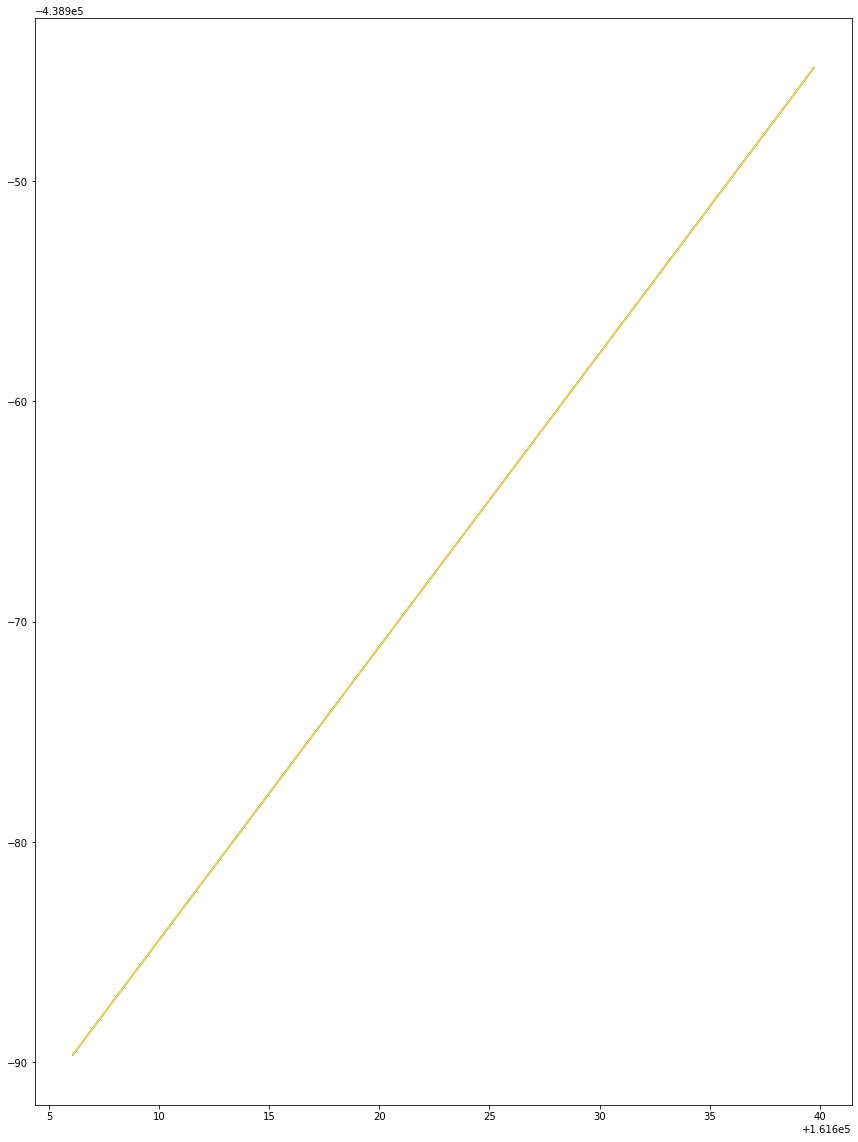

In [18]:
pd.concat([should_overlap2, should_overlap1], 
          axis=0).plot(column="shape_id", 
                       cmap="cividis",
                       figsize=(20, 20))

In [ ]:
# calitp-analytics-data/data-analyses/high_quality_transit_areas/bus_corridors/182_bus.parquet
eric = gpd.read_parquet(f"{GCS_FILE_PATH}bus_corridors/182_bus.parquet")

In [ ]:
tiff = gpd.read_parquet(f"./data/182_bus2.parquet")

In [ ]:
def stats(df):
    print(df.columns)
    print(df.dtypes)
    print(f"# obs: {len(df)}")
    print(f"# unique stops: {df.stop_id.nunique()}")
    print(f"sum am_max stops: {df.am_max_trips.sum()}")
    print(f"sum pm_max stops: {df.am_max_trips.sum()}")
    print(f"# unique hqta_segment_id: {df.hqta_segment_id.nunique()}")

    
def compare(eric, tiff):
    print("***********Eric************")
    stats(eric)
    print("***********Tiff************")
    stats(tiff)

In [ ]:
compare(eric, tiff)

In [ ]:
explore_shapes = [
    "700292_FEB22",
    #"400916_FEB22",
]

explore_stops = [
    #"6535",
    #"5383"
]

explore_stops = tiff[tiff.shape_id.str.startswith("720")].stop_id.unique().tolist()

In [ ]:
tiff[tiff.shape_id.str.startswith("720")].plot()

In [ ]:
eric[eric.shape_id.str.startswith("720")].plot()

In [ ]:
tiff[tiff.stop_id.isin(explore_stops)].plot()

In [ ]:
eric[eric.stop_id.isin(explore_stops)].plot()

In [ ]:
eric[eric.stop_id.isin(explore_stops)].plot(column="segment_sequence")

In [ ]:
tiff[tiff.stop_id.isin(explore_stops)]

In [ ]:
tiff[tiff.stop_id=="6535"]

In [ ]:
tiff[tiff.stop_id.isin(explore_stops)].plot(column="segment_sequence")

In [ ]:
m1 = pd.merge(
    eric,
    tiff,
    on = ["calitp_itp_id", "calitp_url_number", "shape_id", 
          "hqta_segment_id", "segment_sequence", "stop_id"],
    how = "outer",
    #validate="m:m",
    indicator=True
)

In [ ]:
m1._merge.value_counts()

### Find trips that are just AM / PM peak

In [ ]:
# Remove trips that only run during AM/PM peak, because those don't qualify as HQTA
def invalid_trips_only_peak_hours(df):
    trip_cols = ["calitp_itp_id", "trip_id"]
    
    df = df.assign(
        is_am_peak = df.time_of_day.map(lambda x: 1 if x=="AM Peak" 
                                          else 0),
        is_pm_peak = df.time_of_day.map(lambda x: 1 if x=="PM Peak"
                                          else 0),
        is_other = df.time_of_day.map(lambda x: 1 if ((x != "AM Peak") and 
                                                        (x != "PM Peak"))
                                        else 0),
    )
    
    df2 = (df.groupby(trip_cols)
           .agg({"is_am_peak": np.max, 
                 "is_pm_peak": np.max,
                 "is_other": np.max,})
           .reset_index()
          )
    
    # Drop trips that only run AM/PM
    only_peak = df2[(df2.is_am_peak==1) & 
              (df2.is_pm_peak==1) & 
              (df2.is_other==0)].trip_id.compute()
        
    # Return list of trip_ids that are invalid
    return list(only_peak.unique())

In [ ]:
invalid_trips = invalid_trips_only_peak_hours(trip_stops_by_hour)